In [1]:
%matplotlib inline

In [2]:
import supervisely_lib as sly
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
team_name = 'max'
workspace_name = 'test_dtl_segmentation'

src_project_name = 'lemons_annotated'
dst_project_name = 'lemons_annotated_segmentation'

validation_portion = 0.1
image_multiplier = 5

class_bg = sly.ObjClass('bg', sly.Rectangle)
tag_meta_train = sly.TagMeta('train', sly.TagValueType.NONE)
tag_meta_val = sly.TagMeta('val', sly.TagValueType.NONE)

In [4]:
address = os.environ['SERVER_ADDRESS']
token = os.environ['API_TOKEN']

In [5]:
print("Server address: ", address)
print("Your API token: ", token)

Server address:  http://192.168.1.69:5555
Your API token:  OfaV5z24gEQ7ikv2DiVdYu1CXZhMavU7POtJw2iDtQtvGUux31DUyWTXW6mZ0wd3IRuXTNtMFS9pCggewQWRcqSTUi4EJXzly8kH7MJL1hm3uZeM2MCn5HaoEYwXejKT


In [6]:
api = sly.Api(address, token)

In [7]:
team = api.team.get_info_by_name(team_name)
workspace = api.workspace.get_info_by_name(team.id, workspace_name)
print("Current context: Team {!r}, Workspace {!r}".format(team.name, workspace.name))

Current context: Team 'max', Workspace 'test_dtl_segmentation'


In [8]:
src_project = api.project.get_info_by_name(workspace.id, src_project_name)
src_meta_json = api.project.get_meta(src_project.id)
src_meta = sly.ProjectMeta.from_json(src_meta_json)

In [9]:
def process_meta(input_meta):
    output_meta = input_meta.clone()
    output_meta = output_meta.add_obj_class(class_bg)
    output_meta = output_meta.add_img_tag_meta(tag_meta_train)
    output_meta = output_meta.add_img_tag_meta(tag_meta_val)
    return output_meta

In [10]:
dst_meta = process_meta(src_meta)
print(dst_meta)

ProjectMeta:

Object Classes:
Name:  kiwi      Shape: Bitmap       Color: [255, 0, 0]
Name:  lemon     Shape: Bitmap       Color: [81, 198, 170]
Name:  bg        Shape: Rectangle    Color: [236, 238, 221]

Image Tags
Tag Metas:
Name:  train                    Value type:none          Possible values:None      
Name:  val                      Value type:none          Possible values:None      

Object Tags
Tag Metas:
Empty




In [11]:
if api.project.exists(workspace.id, dst_project_name):
    dst_project_name = api.project.get_free_name(workspace.id, dst_project_name)
dst_project = api.project.create(workspace.id, dst_project_name)
print(dst_project)
api.project.update_meta(dst_project.id, dst_meta.to_json())

ProjectInfo(id=793, name='lemons_annotated_segmentation_010', description='', size='0', readme='', workspace_id=45, created_at='2019-03-14T07:08:38.370Z', updated_at='2019-03-14T07:08:38.370Z')


In [12]:
def process(img, ann):
    original = (img, ann)
    flipped = sly.aug.fliplr(*original)

    crops = []
    for cur_img, cur_ann in [original, flipped]:
        for i in range(image_multiplier):
            res_img, res_ann = sly.aug.random_crop_fraction(cur_img, cur_ann, (0.6, 0.8), (0.6, 0.8))
            crops.append((res_img, res_ann))

    results = []
    for cur_img, cur_ann in [original, flipped, *crops]:
        bg_label = sly.Label(sly.Rectangle.from_array(cur_img), class_bg)
        cur_ann = cur_ann.add_label(bg_label)
        tag = sly.Tag(tag_meta_val) if random.random() <= validation_portion else sly.Tag(tag_meta_train)
        cur_ann = cur_ann.add_tag(tag)
        results.append((cur_img, cur_ann))

    return results

In [13]:
aug_results_debug = None

print("Project {!r}: training data preparation".format(src_project.name))
for src_dataset in api.dataset.get_list(src_project.id):
    print('Dataset: {}'.format(src_dataset.name))
    dst_dataset = api.dataset.create(dst_project.id, src_dataset.name)

    for image in tqdm(api.image.get_list(src_dataset.id)):
        img = api.image.download_np(image.id)
        ann_json = api.annotation.download(image.id).annotation
        ann = sly.Annotation.from_json(ann_json, src_meta)

        aug_results = process(img, ann)

        if aug_results_debug is None:
            aug_results_debug = aug_results.copy()

        for aug_img, aug_ann in aug_results:
            dst_img_name = api.image.get_free_name(dst_dataset.id, image.name)
            dst_img_hash = api.image.upload_np(aug_img, image.ext)
            dst_image = api.image.add(dst_dataset.id, dst_img_name, dst_img_hash)
            api.annotation.upload(dst_image.id, aug_ann.to_json())

  0%|          | 0/6 [00:00<?, ?it/s]

Project 'lemons_annotated': training data preparation
Dataset: ds1


100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


Visualization of augmentation results for first image: 


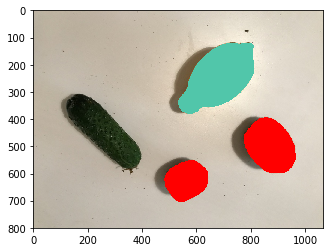

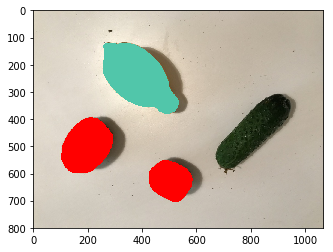

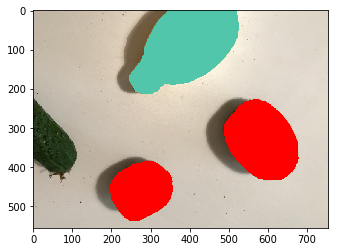

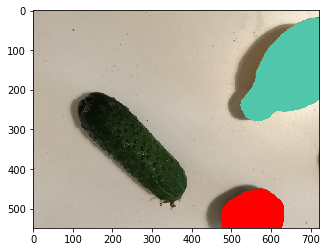

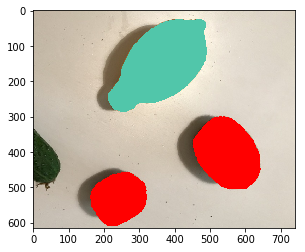

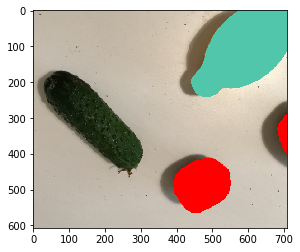

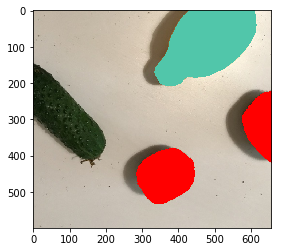

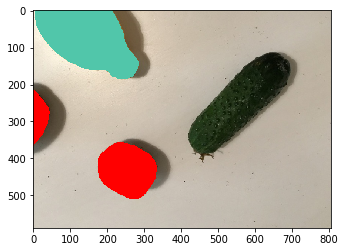

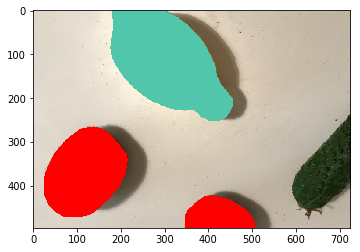

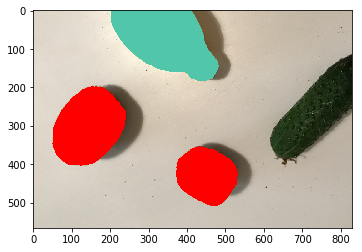

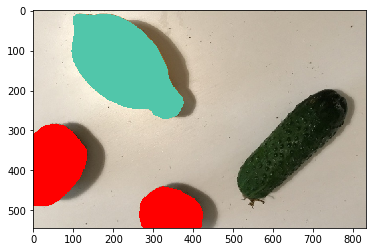

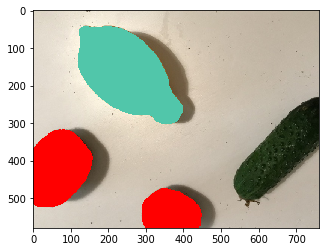

In [14]:
print("Visualization of augmentation results for first image: ")
for aug_img, aug_ann in aug_results_debug:
    draw_img = np.copy(aug_img)
    aug_ann.draw(draw_img)
    plt.figure()
    plt.imshow(draw_img)